# Homework 3: Unsupervised Learning

Due Wednesday 11/24 at 11:59 pm EST

In this notebook, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

In [26]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source: https://chanzuckerberg.github.io/scRNA-python-workshop/preprocessing/00-tabula-muris.html

In [27]:
cell_gene_counts_df = pd.read_csv('data/mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [28]:
cell_metadata_df = pd.read_csv('data/mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [29]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [30]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## Part 1: PCA

**Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [31]:
print(cell_gene_counts_df.mean(axis=0).mean())
print(cell_gene_counts_df.std(axis=0).mean())

-0.005819407100480489
0.9908549659661308


We can see that the dataset is already standardized.

In [32]:
pca = PCA(n_components=50)
pc = pca.fit_transform(cell_gene_counts_df)

pc_df = pd.DataFrame(pc, columns=[f'PC{i}' for i in range(1, 51)])
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,15.353967,22.551441,28.909568,18.160745,-63.669866,63.397362,22.120381,193.168088,5.079597,-12.084365,...,-0.674526,-2.579044,9.004625,-4.790724,4.123303,2.839997,-15.144721,-5.275527,8.591557,1.942073
1,-19.092789,-3.011189,37.073015,-7.781964,-0.324304,-5.520999,1.450259,-0.053578,-2.177491,3.883103,...,0.311992,-0.930019,1.020506,0.308962,-0.195627,0.152242,0.022602,-0.623215,1.421789,-1.038390
2,1.624026,-26.093832,-8.735882,1.431624,3.908803,-0.872088,-2.047060,2.420197,3.514791,3.970539,...,-1.115558,1.162956,0.498912,-0.946955,0.020314,-0.208329,-0.920465,0.074479,-0.661466,-0.214635
3,-15.469770,37.906454,-37.408305,5.952023,-10.229878,4.293254,15.286251,-4.262454,-6.747968,6.366584,...,-5.039796,-1.613465,-0.838912,0.387216,1.187234,-2.494218,-5.031931,0.485765,0.093338,-3.285566
4,-15.223271,-2.999145,38.531674,-6.379690,-6.113618,-4.637019,5.044906,-2.089762,-6.841549,3.252696,...,2.087205,-0.702591,-1.975082,0.334349,-0.582003,1.282031,1.204988,3.463294,2.029459,-1.133661


**Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

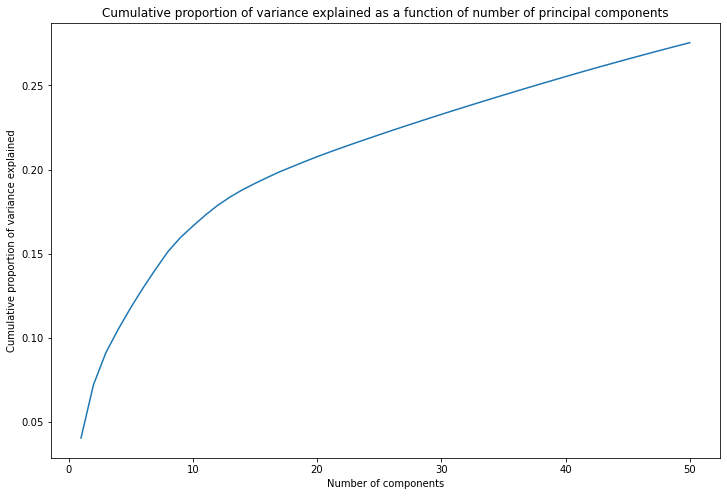

In [33]:
plt.figure(figsize=(12,8))

sns.lineplot(
    x=range(1, len(pca.explained_variance_ratio_)+1),
    y=pca.explained_variance_ratio_.cumsum()
)

plt.xlabel('Number of components')
plt.ylabel('Cumulative proportion of variance explained')
plt.title('Cumulative proportion of variance explained as a function of number of principal components');

It looks like the first $20$ components explain about $20\%$ of the total variance. We can confirm this below

In [34]:
f'About {round(100*pca.explained_variance_ratio_.cumsum()[19], 2)}% of the total variance is explained by the first 20 components which is about {round(pca.explained_variance_.cumsum()[19], 2)}'



'About 20.77% of the total variance is explained by the first 20 components which is about 3989.0'

**For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [35]:
components = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i}' for i in range(1,51)],
    index=cell_gene_counts_df.columns
)

components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0610005C13Rik,0.000837,-0.001160,0.004848,-0.000903,-0.007460,0.001687,0.000577,-0.004607,-0.006558,0.003205,...,-0.000152,0.003973,-0.000216,-0.004314,0.001345,-0.002670,0.001757,-0.004957,-0.007158,0.003841
0610007C21Rik,0.006774,-0.006888,-0.006253,0.000179,-0.014241,0.004574,0.007347,-0.002526,-0.012677,0.007285,...,0.003844,-0.001124,-0.000041,0.001658,0.011148,0.009277,-0.004935,-0.004295,0.003925,0.002398
0610007L01Rik,0.003400,0.005564,-0.009035,0.007410,-0.004466,0.002710,0.001636,0.001063,-0.002544,-0.000451,...,-0.002438,-0.001964,-0.001487,0.006183,0.004105,0.000126,0.005913,-0.000404,-0.003228,-0.009970
0610007N19Rik,-0.002282,0.007633,-0.000754,0.001698,-0.016108,0.013897,-0.041249,-0.007977,-0.000245,-0.002618,...,-0.002275,-0.004069,0.000016,0.000692,-0.001211,0.001845,0.003818,0.010735,0.007324,0.001460
0610007P08Rik,0.005332,-0.002157,-0.005430,0.000568,-0.000213,-0.000175,0.002253,-0.001389,-0.004391,0.003169,...,-0.000631,-0.002963,-0.001949,-0.001350,-0.012060,-0.005023,0.006842,-0.006029,-0.000033,0.006413


Top 10 loadings (weights) and their corresponding gene names, sorted by absolute values for the weights in decreasing:

In [36]:
pd.DataFrame(
    components.PC1.abs().sort_values(ascending=False)[0:10]
).reset_index().rename(columns={'index':'Gene',  'PC1':'Weight'})[['Weight', 'Gene']]

,Weight,Gene
0,0.026673,Nsg2
1,0.026595,St8sia3
2,0.026588,Ptpn5
3,0.026539,Kcnj4
4,0.026347,Rasgef1a
5,0.026221,Camkv
6,0.026173,Hpca
7,0.026022,Cpne5
8,0.025979,Nrsn2
9,0.025853,Erc2


Hence, these are the 10 genes which are weighted the most in the first principal component.

**Plot the projection of the data onto the first two principal components using a scatter plot.**

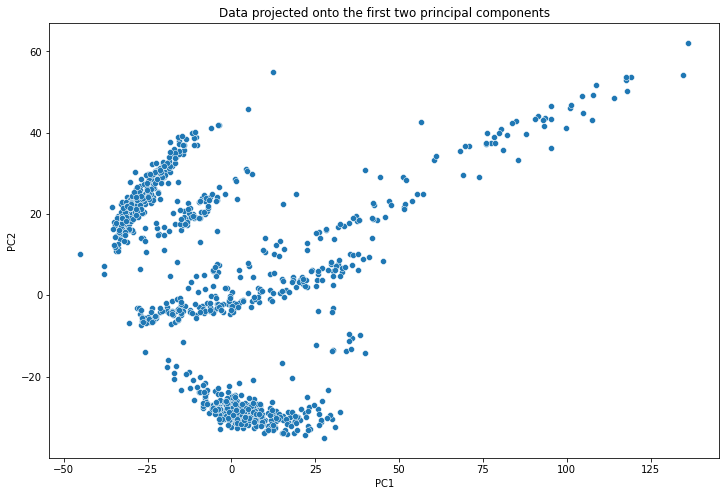

In [37]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', data=pc_df)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data projected onto the first two principal components');

**Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.

In [38]:
df = pc_df.join(cell_metadata_df)
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC49,PC50,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,15.353967,22.551441,28.909568,18.160745,-63.669866,63.397362,22.120381,193.168088,5.079597,-12.084365,...,8.591557,1.942073,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,-19.092789,-3.011189,37.073015,-7.781964,-0.324304,-5.520999,1.450259,-0.053578,-2.177491,3.883103,...,1.421789,-1.038390,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,1.624026,-26.093832,-8.735882,1.431624,3.908803,-0.872088,-2.047060,2.420197,3.514791,3.970539,...,-0.661466,-0.214635,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,-15.469770,37.906454,-37.408305,5.952023,-10.229878,4.293254,15.286251,-4.262454,-6.747968,6.366584,...,0.093338,-3.285566,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,-15.223271,-2.999145,38.531674,-6.379690,-6.113618,-4.637019,5.044906,-2.089762,-6.841549,3.252696,...,2.029459,-1.133661,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0


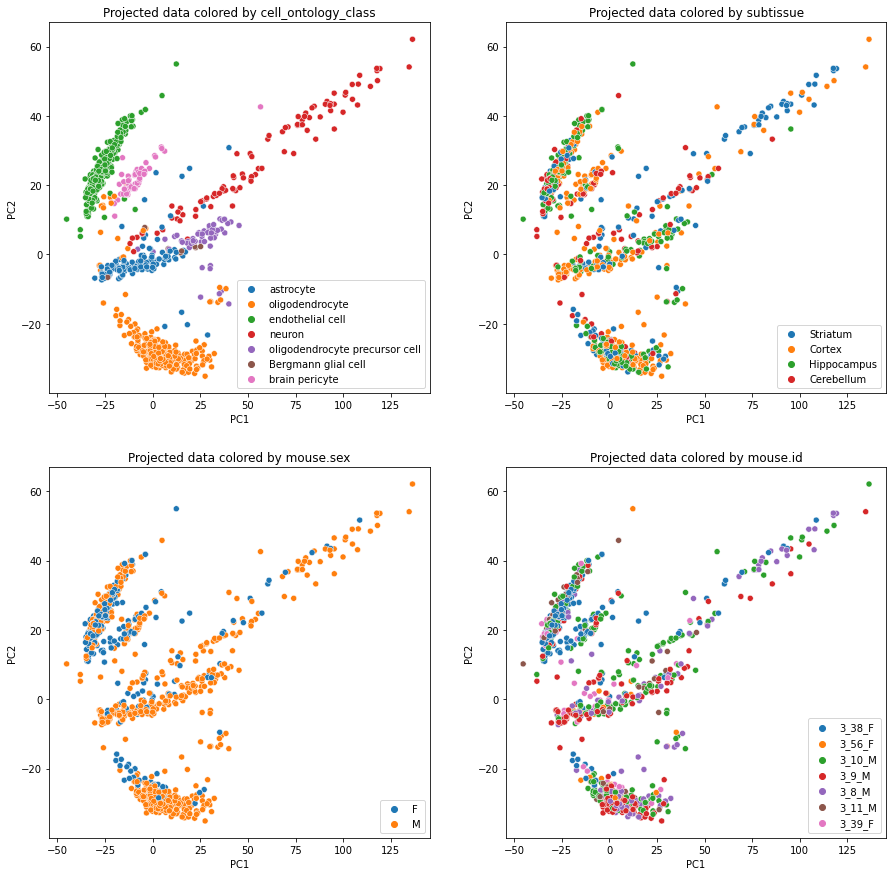

In [39]:
coloredBy = ['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

k = 0
for i in range(2):
    for j in range(2):
        sns.scatterplot(x='PC1', y='PC2', data=df, hue=df[coloredBy[k]], ax=ax[i][j])
        ax[i][j].set_title(f'Projected data colored by {coloredBy[k]}')
        ax[i][j].legend(loc=4)
        k += 1
    
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel('PC1')
        ax[i][j].set_ylabel('PC2')

**Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

The first subplot describes well the subclasses for cell_ontology_class. The clusters present roughly corresond to the categories present in cell_ontology_class. The other subplots have overlap between points of different clusters and don't explain well the property by which they are colored. Hence, PC1 and PC2 together nicely describe the cell_ontology_class of the cells. We can say that they correspond to this particular aspect of the cells.

## Part 2: K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [40]:
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    # number of samples
    m = X.shape[0]
    
    # dimension
    n = X.shape[1]
    
    # initialize means indices
    if k < m+1:
        # without replacement
        idx = random.sample(population=range(m), k=k)
    else:
        # with replacement
        idx = random.choice(population=range(m), k=k)
    
    # initialize cluster means
    means = X[idx]
    
    # list to indicate cluster assignments
    clusters = []

    # to keep track of number of iterations passed
    n_iters = 0
    
    while n_iters < iters:
        # calculate distance of each sample point from each cluster mean
        distances = cdist(X, means ,'euclidean')
        
        # assign each sample point the closest cluster depending upon their
        # distance from the cluster means
        clusters = np.array([np.argmin(i) for i in distances])
        
        # update the cluster means after assigning new clusters
        new_means = []
        for c in range(k):
            new_means.append(X[clusters == c].mean(axis=0))
        
        new_means = np.vstack(new_means)
        
        # stopping condition
        if np.array_equal(new_means, means):
            print('Finished K-Means on iteration: {}'.format(n_iters))
            means = new_means
            break
        else:
            means = new_means
            n_iters += 1
            
        if n_iters == iters:
            print('Maximum number of iterations reached')
        
    distances = cdist(X, means ,'euclidean') 
    clusters = np.array([np.argmin(i) for i in distances])
    
    return clusters
        

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

Text(0, 0.5, '$x_2$')

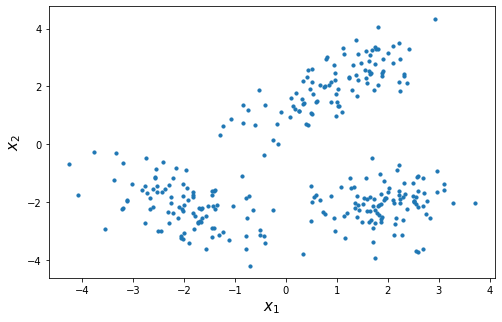

In [41]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

Finished K-Means on iteration: 3


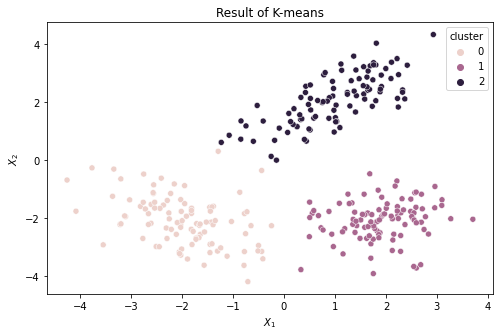

In [42]:
# run K-means to obtain clusters
cluster = kmeans(X, 3)

X_df = pd.DataFrame(X, columns=[f'col{i+1}' for i in range(X.shape[1])])
X_df['cluster'] = cluster

plt.figure(figsize=(8, 5))
sns.scatterplot(x='col1', y='col2', data=X_df, hue='cluster')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Result of K-means');

**Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [43]:
# run K-Means to obtain clusters
clusters = kmeans(X=pc[:, 0:20], k=20, iters=100)
f'{clusters.shape}'

Finished K-Means on iteration: 17


'(1000,)'

## Part 3: t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [44]:
kernelPca = TSNE(n_components=2)
kernelPc = kernelPca.fit_transform(pc[:, 0:20])
kernelPc.shape

/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vishweshwartyagi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)

**Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

In [45]:
kernelPc_df = pd.DataFrame(kernelPc, columns=[f'PC{i}' for i in range(1, 3)])
kernel_df = kernelPc_df.join(cell_metadata_df)

kernel_df.head()

,PC1,PC2,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,-1.664850,-14.419493,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,5.886659,-13.611439,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,-32.580444,-5.075687,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,40.331879,26.522926,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,7.496903,-16.428980,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0


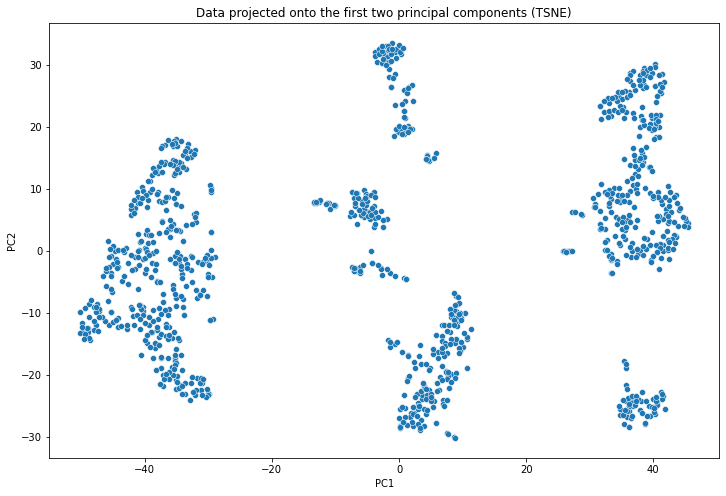

In [46]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', data=kernel_df)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data projected onto the first two principal components (TSNE)');

**Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

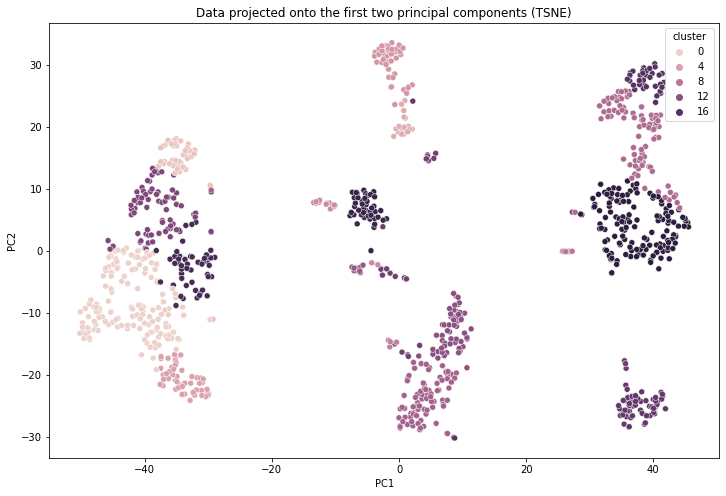

In [47]:
kernel_df['cluster'] = clusters
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', data=kernel_df, hue='cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data projected onto the first two principal components (TSNE)');

**Why is there overlap between points in different clusters in the t-SNE plot above?**

In K-Means, all of the $M$ sample points of $D$ dimension are assigned to a unique cluster that is closest to them, and hence, there cannot be any overlap between different clusters in the $D-$dimensional space. Had we been able to plot and color the $20$ dimensional projections of PCA by their clusters, we would see no overlap in the $20-$dimensional space. However, in our case, to visualize the results of K-Means, we're again projecting the projections of PCA (using PCA 20 components) to a $2-$dimensional space, which will not preserve the mutual distance and positioning between these points and hence, if we were to use the same cluster labels as that of K-Means (which we ran on the projections of PCA), we are likely to see overlap. This explains the overlap between points in different clusters.

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.